<a href="https://colab.research.google.com/github/timothywangdev/style-transfer/blob/main/Copy_of_Img2Img_Stable_Diffusion_with_Diffusers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Mon Jan 16 19:45:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

The below line is required as Hugging Face Diffusers on PyPi is not fully updated with StableDiffusion Pipeline. Hence we are are downloading it directly from Github. 

In [ ]:
! pip install https://github.com/huggingface/diffusers/archive/main.zip -qUU --force-reinstall


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.24.1 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.1 which is incompatible.
google-cloud-bigquery 3.4.1 requires packaging<22.0.0dev,>=14.3, but you have packaging 23.0 which is incompatible.
aiohttp 3.8.3 requires charset-normalizer<3.0,>=2.0, but you have charset-normalizer 3.0.1 which is incompatible.


In [ ]:
!pip install -qq -U transformers ftfy
!pip install -qq "ipywidgets>=7,<8"

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [ ]:
# import inspect
# from typing import List, Optional, Union

# import numpy as np
# import torch

# import PIL
# from diffusers import AutoencoderKL, DDIMScheduler, DiffusionPipeline, PNDMScheduler, UNet2DConditionModel
# from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
# from tqdm.auto import tqdm
# from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer


# def preprocess(image):
#     w, h = image.size
#     w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
#     image = image.resize((w, h), resample=PIL.Image.LANCZOS)
#     image = np.array(image).astype(np.float32) / 255.0
#     image = image[None].transpose(0, 3, 1, 2)
#     image = torch.from_numpy(image)
#     return 2.0 * image - 1.0


# class StableDiffusionImg2ImgPipeline(DiffusionPipeline):
#     def __init__(
#         self,
#         vae: AutoencoderKL,
#         text_encoder: CLIPTextModel,
#         tokenizer: CLIPTokenizer,
#         unet: UNet2DConditionModel,
#         scheduler: Union[DDIMScheduler, PNDMScheduler],
#         safety_checker: StableDiffusionSafetyChecker,
#         feature_extractor: CLIPFeatureExtractor,
#     ):
#         super().__init__()
#         scheduler = scheduler.set_format("pt")
#         self.register_modules(
#             vae=vae,
#             text_encoder=text_encoder,
#             tokenizer=tokenizer,
#             unet=unet,
#             scheduler=scheduler,
#             safety_checker=safety_checker,
#             feature_extractor=feature_extractor,
#         )

#     @torch.no_grad()
#     def __call__(
#         self,
#         prompt: Union[str, List[str]],
#         init_image: torch.FloatTensor,
#         strength: float = 0.8,
#         num_inference_steps: Optional[int] = 50,
#         guidance_scale: Optional[float] = 7.5,
#         eta: Optional[float] = 0.0,
#         generator: Optional[torch.Generator] = None,
#         output_type: Optional[str] = "pil",
#     ):

#         if isinstance(prompt, str):
#             batch_size = 1
#         elif isinstance(prompt, list):
#             batch_size = len(prompt)
#         else:
#             raise ValueError(f"`prompt` has to be of type `str` or `list` but is {type(prompt)}")

#         # set timesteps
#         accepts_offset = "offset" in set(inspect.signature(self.scheduler.set_timesteps).parameters.keys())
#         extra_set_kwargs = {}
#         offset = 0
#         if accepts_offset:
#             offset = 1
#             extra_set_kwargs["offset"] = 1

#         self.scheduler.set_timesteps(num_inference_steps, **extra_set_kwargs)

#         # encode the init image into latents and scale the latents
#         init_latents = self.vae.encode(init_image.to(self.device)).sample()
#         init_latents = 0.18215 * init_latents

#         # prepare init_latents noise to latents
#         init_latents = torch.cat([init_latents] * batch_size)

#         # get the original timestep using init_timestep
#         init_timestep = int(num_inference_steps * strength) + offset
#         init_timestep = min(init_timestep, num_inference_steps)
#         timesteps = self.scheduler.timesteps[-init_timestep]
#         timesteps = torch.tensor([timesteps] * batch_size, dtype=torch.long, device=self.device)

#         # add noise to latents using the timesteps
#         noise = torch.randn(init_latents.shape, generator=generator, device=self.device)
#         init_latents = self.scheduler.add_noise(init_latents, noise, timesteps)

#         # get prompt text embeddings
#         text_input = self.tokenizer(
#             prompt,
#             padding="max_length",
#             max_length=self.tokenizer.model_max_length,
#             truncation=True,
#             return_tensors="pt",
#         )
#         text_embeddings = self.text_encoder(text_input.input_ids.to(self.device))[0]

#         # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
#         # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
#         # corresponds to doing no classifier free guidance.
#         do_classifier_free_guidance = guidance_scale > 1.0
#         # get unconditional embeddings for classifier free guidance
#         if do_classifier_free_guidance:
#             max_length = text_input.input_ids.shape[-1]
#             uncond_input = self.tokenizer(
#                 [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
#             )
#             uncond_embeddings = self.text_encoder(uncond_input.input_ids.to(self.device))[0]

#             # For classifier free guidance, we need to do two forward passes.
#             # Here we concatenate the unconditional and text embeddings into a single batch
#             # to avoid doing two forward passes
#             text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

#         # prepare extra kwargs for the scheduler step, since not all schedulers have the same signature
#         # eta (η) is only used with the DDIMScheduler, it will be ignored for other schedulers.
#         # eta corresponds to η in DDIM paper: https://arxiv.org/abs/2010.02502
#         # and should be between [0, 1]
#         accepts_eta = "eta" in set(inspect.signature(self.scheduler.step).parameters.keys())
#         extra_step_kwargs = {}
#         if accepts_eta:
#             extra_step_kwargs["eta"] = eta

#         latents = init_latents
#         t_start = max(num_inference_steps - init_timestep + offset, 0)
#         for i, t in tqdm(enumerate(self.scheduler.timesteps[t_start:])):
#             # expand the latents if we are doing classifier free guidance
#             latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents

#             # predict the noise residual
#             noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

#             # perform guidance
#             if do_classifier_free_guidance:
#                 noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
#                 noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

#             # compute the previous noisy sample x_t -> x_t-1
#             latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs)["prev_sample"]

#         # scale and decode the image latents with vae
#         latents = 1 / 0.18215 * latents
#         image = self.vae.decode(latents)

#         image = (image / 2 + 0.5).clamp(0, 1)
#         image = image.cpu().permute(0, 2, 3, 1).numpy()

#         # run safety checker
#         safety_cheker_input = self.feature_extractor(self.numpy_to_pil(image), return_tensors="pt").to(self.device)
#         image, has_nsfw_concept = self.safety_checker(images=image, clip_input=safety_cheker_input.pixel_values)

#         if output_type == "pil":
#             image = self.numpy_to_pil(image)

#         return {"sample": image, "nsfw_content_detected": has_nsfw_concept}

In [ ]:
#!wget https://raw.githubusercontent.com/huggingface/diffusers/4674fdf807cdefd4db1758067c0207872d805f8c/examples/inference/image_to_image.py

In [ ]:
! pip install --ignore-installed Pillow==9.0.0


# this fixes the module 'PIL.Image' has no attribute 'Resampling' error


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Pillow-9.0.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.3 MB)


In [ ]:
from torch import autocast
import torch
import requests
from PIL import Image
from io import BytesIO

from diffusers import StableDiffusionImg2ImgPipeline


/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
# load the pipeline
device = "cuda"
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    revision="fp16", 
    torch_dtype=torch.float16,
    use_auth_token=True
).to(device)

Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/307 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/572 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/246M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/788 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


In [ ]:
# let's download an initial image
url = "https://e9g2x6t2.rocketcdn.me/wp-content/uploads/2020/11/Professional-Headshot-Poses-Blog-Post.jpg"

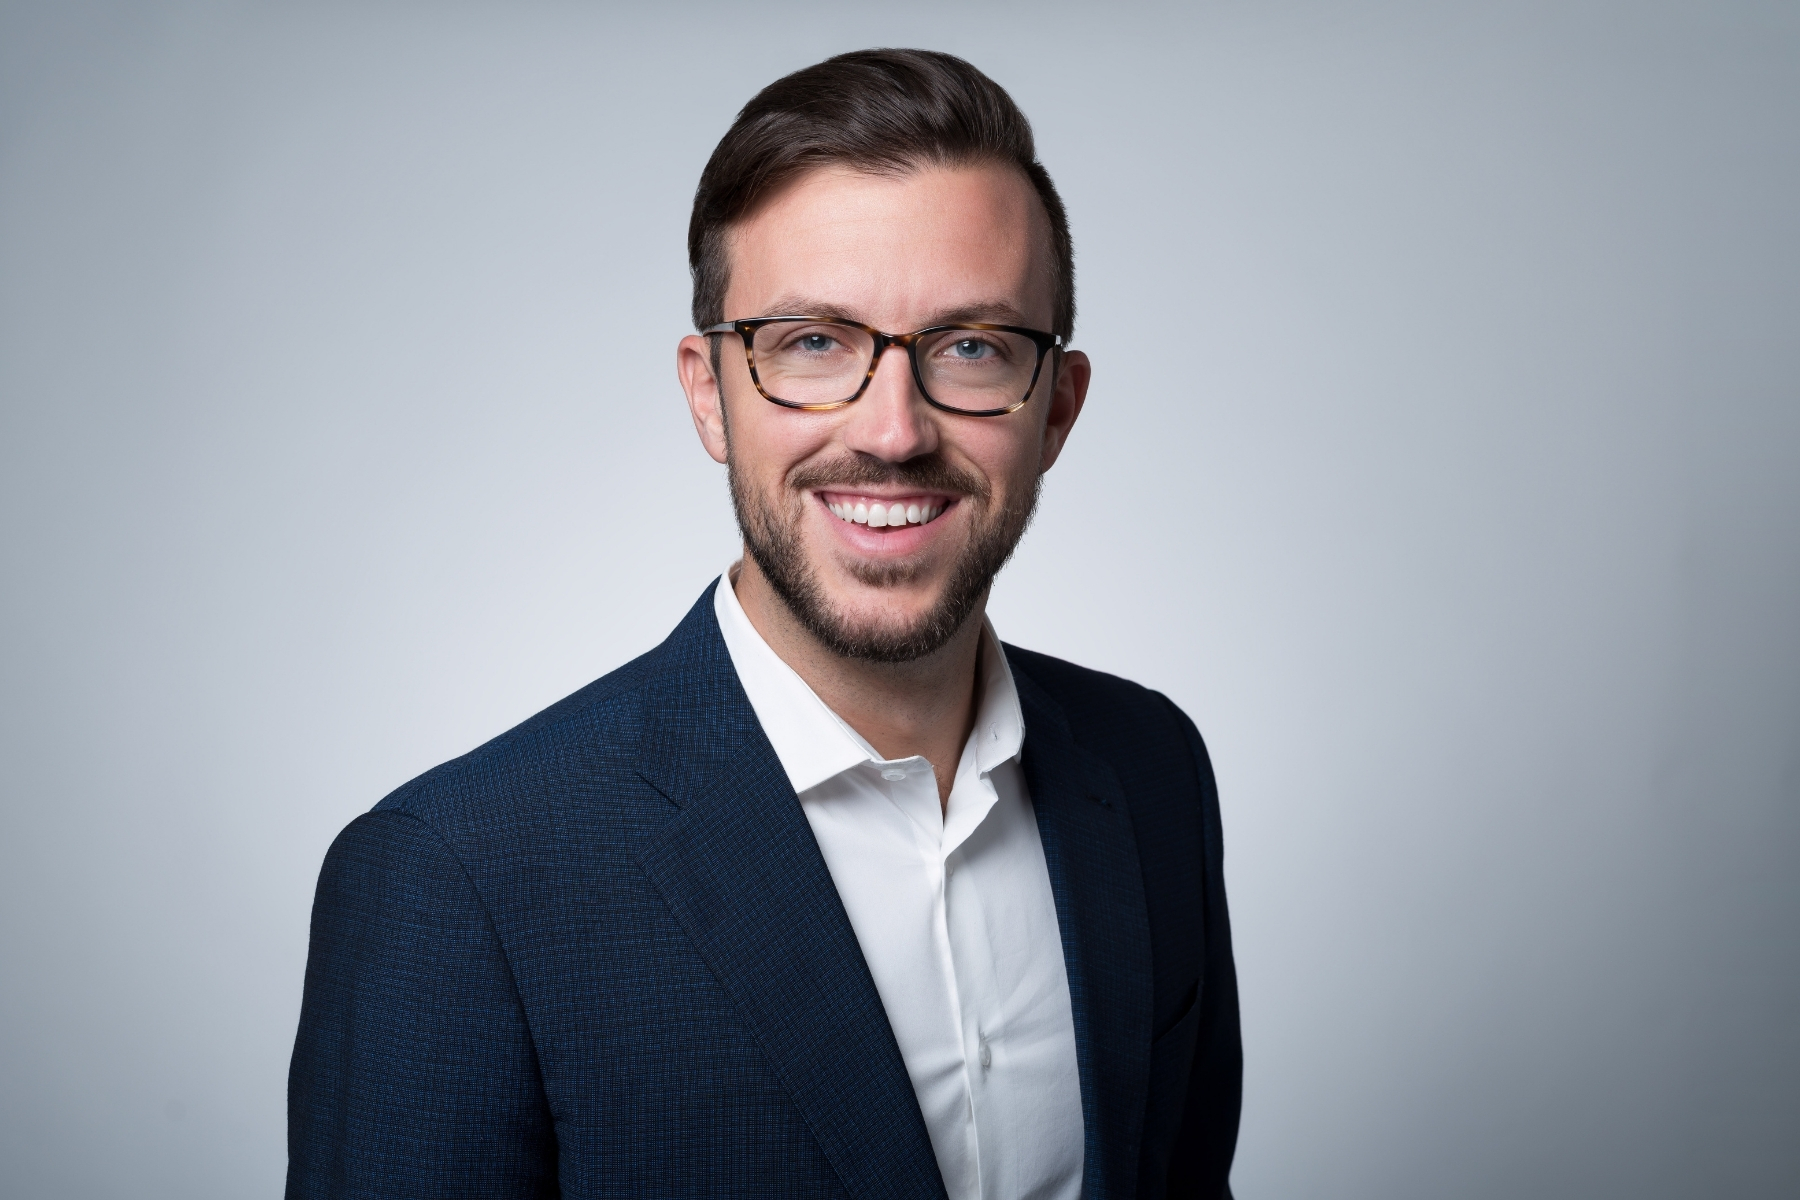

In [ ]:
response = requests.get(url)
init_image = Image.open(BytesIO(response.content)).convert("RGB")
init_image

In [ ]:
init_image = init_image.resize((768, 512))
#init_image = preprocess(init_image)

In [ ]:
prompt = "Divine angel"

In [ ]:
with autocast("cuda"):
    images = pipe(prompt=prompt, init_image=init_image, strength=0.75, guidance_scale=7.5)


  0%|          | 0/37 [00:00<?, ?it/s]

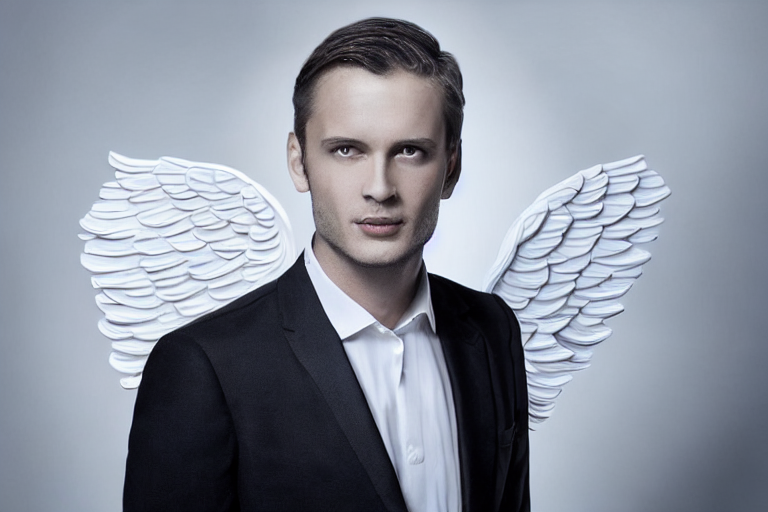

In [ ]:
images.images[0]

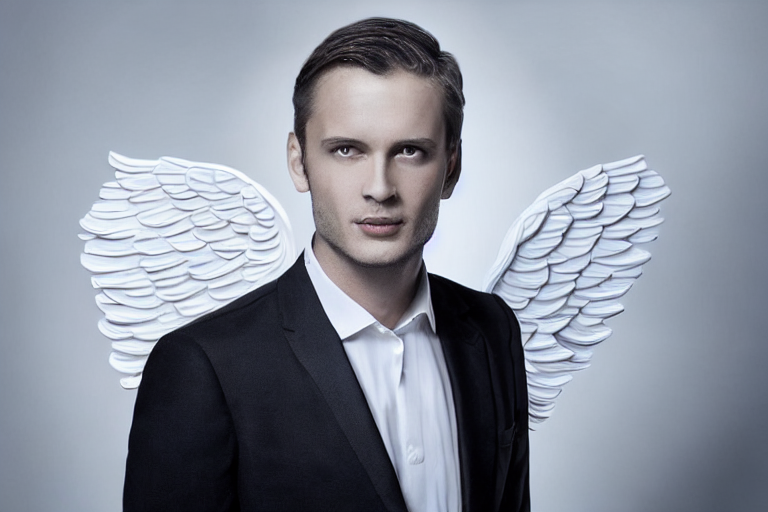

In [ ]:
images.images[0]